# Chronos T5 for Time Series Forecasting
In this notebook, we’ll get hands-on with using **Chronos T5** model to tackle a forecasting task. Along the way, you’ll explore the details of the model and pick up key ideas that you can apply to your own projects with your own data. By the end, you’ll have a stronger foundation to use **Chronos T5** for solving your own forecasting problems.

## Import Libraries

This notebook relies on a set of libraries for time series forecasting and analysis. These include:

- **Pandas / NumPy** for tabular and numerical operations  
- **Hugging Face Datasets** for loading benchmark datasets  
- **GluonTS** for time series modeling  
- **Custom `genai4t` utilities** developed for this book to streamline preprocessing, training, and evaluation  
- **Matplotlib** for visualization  

We organize the imports below for clarity.

In [1]:
# -----------------------------------------------------------
# Imports: Required Libraries for Forecasting Experiments
# -----------------------------------------------------------

# --- Data Manipulation and Numerical Computation ---
import os  # For interacting with the operating system (e.g., file paths)
import pandas as pd  # For handling tabular data
import numpy as np  # For numerical operations on arrays

# --- Data Loading and Preprocessing ---
from datasets import load_dataset  # Hugging Face datasets library for standardized data loading
from genai4t.data.processing import dataset_to_pandas  # Custom utility to convert Hugging Face datasets to pandas DataFrames

# --- Configuration Management and Utilities ---
from omegaconf import OmegaConf  # Hydra-compatible tool for managing experiment configurations
from genai4t.utils import get_torch_device, set_random_state  # Helpers for device selection and reproducibility

# --- Forecasting Model Utilities ---
from genai4t.model.utils import fit_model  # Function to train GluonTS-based models
from genai4t.forecasting.util import create_predictions_dataframe  # Converts model outputs into a pandas DataFrame format
from gluonts.model.forecast import SampleForecast  # GluonTS forecast object used for evaluating model predictions
from gluonts.evaluation.backtest import _to_dataframe # Transform datasets to dataframs
# --- Visualization ---
from matplotlib import pyplot as plt  # For plotting time series and forecasts
from genai4t.plot_style import plot_style # For plotting style
import seaborn as sns 

# --- Miscellaneous ---
from itertools import islice  # Useful for slicing iterables (e.g., previewing data)
from typing import List  # Type hinting support

## Experiment Configuration

To keep our experiments organized, we define all key parameters (e.g., model hyperparameters, dataset settings, training options) as configuration dictionaries

This allows us to:
- Easily adjust settings in one place
- Avoid hardcoding values throughout the notebook

In [2]:
ENV_CONFIG = {
        # Whether to use GPU acceleration if available
        # Set to True to enable GPU usage for faster training
        # Will fall back to CPU if GPU is not available
        "use_cuda": True,
        
        # Set random seed for reproducibility
        # Using a fixed seed ensures you get the same results each time you run the code
        # Change this value to get different but still reproducible results
        "random_state": 2024
    }

DATA_CONFIG = {
        # Name of the dataset to load from HuggingFace hub
        # This dataset contains exchange rate data
        "name": "gatam4t/genai4t_exchange_rate",

        # Date to split data into training and test sets
        # Data before this date will be used for training
        # Data after this date will be used for testing
        "split_date": "2016-01-01",

        # Number of future time steps to predict
        "prediction_length": 1,

        # Number of past time steps to use for making predictions
        # Model will look at 30 days of history
        "context_length": 30,

        # Number of sample paths to generate for probabilistic forecasting
        # Higher values give better uncertainty estimates but take longer
        "num_samples": 20,

        # Frequency of the time series data
        # 'B' means business days (Monday-Friday)
        "freq": 'B',

        # Number of time series to process simultaneously during training
        # Larger batch sizes can speed up training but use more memory
        "batch_size": 32,

        # Number of batches in an epoch
        "num_batches_per_epoch": 50,
    }

In [3]:
# --------------------------------------------
# Load Configuration and Set Up Environment
# --------------------------------------------

# Select computation device: GPU (if available) or CPU
device = get_torch_device()

# Set random seed for reproducibility
# Ensures consistent results across multiple runs
set_random_state(ENV_CONFIG["random_state"])

Seed set to 2024


## Load Data

For this experiment, we’ll use the **Exchange Rate** dataset—a multivariate time series dataset commonly used in academic benchmarks for forecasting models. It consists of daily exchange rates for eight currencies (Australia, United Kingdom, Canada, Switzerland, China, Japan, New Zealand, and Singapore)


This dataset was one of the benchmarks used in the evaluation of the **Chronos** paper, and is originally available through the Hugging Face Datasets Hub:

[Original Source (Chronos)](https://huggingface.co/datasets/autogluon/chronos_datasets/viewer/exchange_rate)

To make access easier and ensure long-term reproducibility, a copy of the dataset has been published in the Hugging Face repo associated with this book. We'll load it directly from there.

While we use the Exchange Rate dataset here, the methods in this notebook work with any dataset in wide time series format (i.e., one time series per column) with minimal adjustments.

In [4]:
# ------------------------------------------------------
# Load Dataset from Hugging Face and Convert to Pandas
# ------------------------------------------------------

# Load dataset split from the Hugging Face hub
dataset = load_dataset(DATA_CONFIG["name"], split='train')

# Convert to pandas DataFrame and enforce consistent time frequency
level_data = dataset_to_pandas(dataset).asfreq(DATA_CONFIG["freq"])

# Display the first few rows of the DataFrame
level_data.head()

,currency_1,currency_2,currency_3,currency_4,currency_5,currency_6,currency_7,currency_8
timestamp,,,,,,,,
1990-01-01,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.5930,0.525486
1990-01-02,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.5940,0.523972
1990-01-03,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.5973,0.526316
1990-01-04,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.5970,0.523834
1990-01-05,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.5985,0.527426


In [5]:
# compute returns
data = np.log(level_data).diff().dropna()
data.head()

,currency_1,currency_2,currency_3,currency_4,currency_5,currency_6,currency_7,currency_8
timestamp,,,,,,,,
1990-01-02,-0.004722,-0.000621,-0.000690,-0.001078,0.0,0.003649,0.001685,-0.002885
1990-01-03,0.006248,0.011916,-0.000086,0.023394,0.0,0.016188,0.005540,0.004464
1990-01-04,-0.000890,0.004715,0.001206,0.003248,0.0,-0.003159,-0.000502,-0.004727
1990-01-05,-0.001400,0.009727,-0.000086,0.008625,0.0,-0.001871,0.002509,0.006834
1990-01-08,0.002164,0.000423,-0.001120,-0.002097,0.0,-0.007667,0.009148,-0.002371


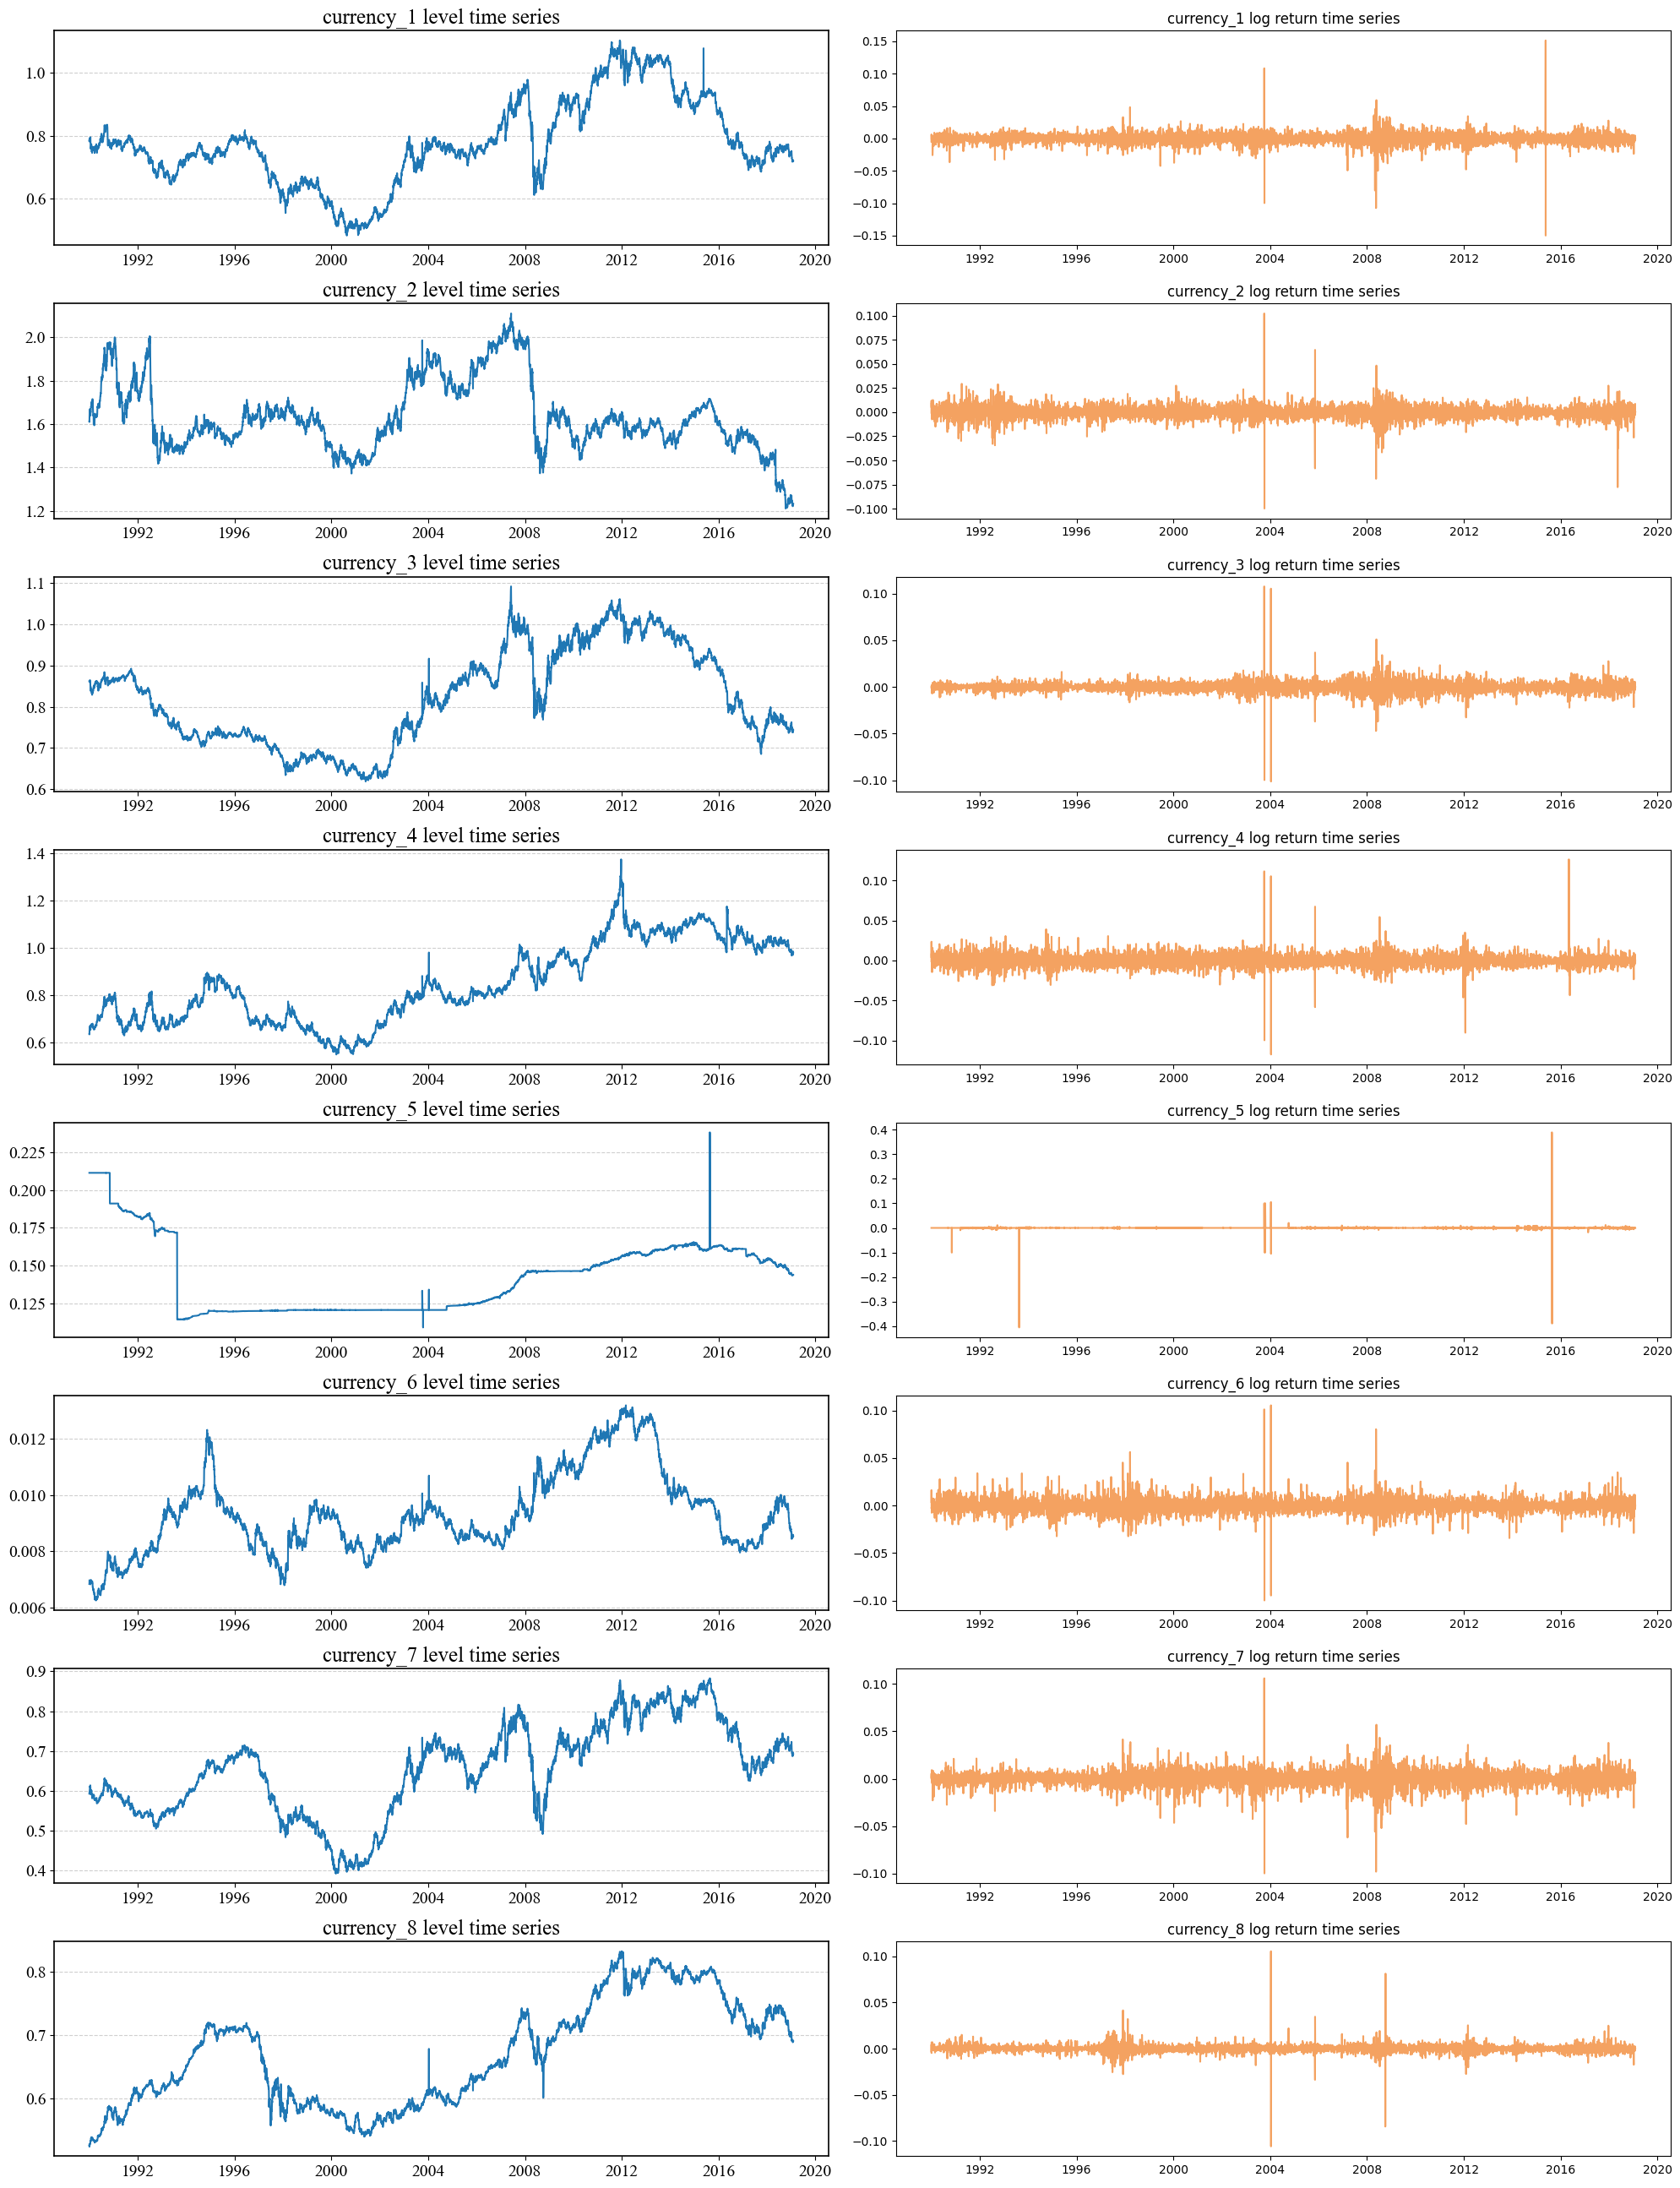

In [6]:
n_series = len(data.columns)
f, axs = plt.subplots(n_series, 2, figsize=(20, 26))
for i, tname in enumerate(data.columns):
    # Plot level time series
    axs[i][0].plot(level_data[tname])
    axs[i][0].set_title(f"{tname} level time series")
    plot_style.apply_plot_style(axs[i][0])
    plot_style.apply_grid(axs[i][0])
    
    # Plot log return time series
    axs[i][1].plot(data[tname], color="#F4A261")
    axs[i][1].set_title(f"{tname} log return time series")
    plot_style.apply_plot_style(axs[i][0])
    plot_style.apply_grid(axs[i][0])

### Convert to GluonTS Format

To use GluonTS models, we need to convert our pandas DataFrame into a **GluonTS-compatible dataset**.

We've already covered how to do this in the `GluonTS Tutorial`, and we've refactored the logic into a utility function called `split_train_test_datasets` for reuse across different notebooks.

In [7]:
from genai4t.forecasting.data import split_train_test_datasets

In [8]:
train_ds, test_ds = split_train_test_datasets(
    data,
    DATA_CONFIG['prediction_length'],
    DATA_CONFIG['split_date'],
    DATA_CONFIG['freq'])

number of windows: 803


## Model: Chronos T5

Transformers have shown remarkable success in modeling long-range dependencies across various sequential data types, such as text, audio, and video. Naturally, this leads to the question: Can Transformers also be effectively applied to time series data?


As discussed in Chapter 5 of the book, time series, like text are inherently sequential. One promising idea for adapting Transformers to time series problems is to convert continuous time series values into discrete tokens. This is the core idea behind [Chronos: Learning the Language of Time Series](https://arxiv.org/abs/2403.07815) (Ansari et al., 2024).

Chronos operates by first normalizing and then quantizing time-series data, transforming continuous numerical values into discrete tokens. These tokens are then fed into standard Transformer architectures, such as T5 (encoder-decoder) or GPT-2 (decoder-only), without requiring any architectural modifications.

In the experiments that follow, we will explore the performance of Chronos using the T5-small architecture. Readers are, of course, encouraged to experiment with other variants (e.g., T5-base, GPT-2). For full architectural details, see the original paper [Chronos: Learning the Language of Time Series](https://arxiv.org/abs/2403.07815). 

Figure below from the paper provides a visual overview of the model.




![](./../../assets/figures/chapter05/chronos-paper-figure-1.png)

#### Evaluation setup

We’ll evaluate Chronos on the Exchange Rate dataset. 

An important note is that part of this dataset was used to train the original Chronos model. Following the paper's setup and repository, we evaluate performance on unseen portions of the data. 

**Key difference in our setup**:
- The original model was trained on raw level data (i.e., actual exchange rates).
- In contrast, we evaluate Chronos on returns data, to test how well the model generalizes under a different data transformation.

Readers are encouraged to explore alternative data setting


### Using Chronos
Chronos is available via the official chronos Python package: https://github.com/amazon-science/chronos-forecasting

The main entry point is the ChronosPipeline class, which simplifies model training and inference.

In [9]:
from chronos import ChronosPipeline

Since the Chronos model is already pre-trained, using it is straightforward. We can apply it out of the box to generate time series forecasts.

To do this, we simply:

- Create an instance of the ChronosPipeline
- Call its .predict() method to produce forecasts

In [10]:
chronos_pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-small", device_map=device)

chronos_pipeline

To use a ChronosPipeline instance, we need to format the data according to its expected input structure.

According to the official documentation, the input and output formats are as follows:


- context: 1D tensor, list of 1D tensors, or left-padded 2D tensor (batch first)
- quantiles: float32 tensor with shape `[batch_size, prediction_length, num_quantile_levels]`

To prepare the input in this expected format, we'll make use of a GluonTS DataLoader.

In [11]:
from genai4t.forecasting.predictors.util import get_prediction_splitter
from gluonts.dataset.loader import InferenceDataLoader
from gluonts.torch.batchify import batchify

prediction_splitter = get_prediction_splitter(
    DATA_CONFIG['context_length'],
    DATA_CONFIG['prediction_length']
)

test_dl = InferenceDataLoader(
    test_ds.input,
    transform=prediction_splitter,
    batch_size=1,
    stack_fn=batchify
)

batch = next(iter(test_dl))
batch

{'start': [Period('1990-01-02', 'B')],
 'item_id': ['currency_1'],
 'past_target': tensor([[-0.0059, -0.0063, -0.0047, -0.0007,  0.0000, -0.0070, -0.0031, -0.0051,
          -0.0036,  0.0004,  0.0000, -0.0040,  0.0010, -0.0021, -0.0054,  0.0000,
           0.0000,  0.0074,  0.0084,  0.0000, -0.0067,  0.0028, -0.0057, -0.0049,
           0.0000,  0.0081, -0.0029,  0.0078, -0.0033,  0.0001]]),
 'future_target': tensor([], size=(1, 0)),
 'past_is_pad': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]),
 'forecast_start': [Period('2016-01-04', 'B')]}

To make a prediction, we call the `predict` method.

In [12]:
sample_forecast = chronos_pipeline.predict(
    batch['past_target'],
    prediction_length=DATA_CONFIG['prediction_length'],
    num_samples=DATA_CONFIG['num_samples']
)

sample_forecast.shape  # (batch_size, num_samples, prediction_length)

torch.Size([1, 20, 1])

Now, to stay consistent with the APIs used throughout the book, we’ll wrap `Chronos` in a custom predictor that is compatible with the `GluonTS API`.

In [13]:
from gluonts.model.predictor import Predictor
from typing import Optional
from gluonts.dataset.common import Dataset
from gluonts.torch.batchify import batchify
from chronos import ChronosPipeline
from gluonts.dataset.loader import InferenceDataLoader
from gluonts.model.forecast import SampleForecast
from gluonts.dataset.field_names import FieldName
from genai4t.forecasting.predictors.util import get_prediction_splitter


class ChronosPredictor(Predictor):
    """A predictor that uses the Chronos T5 model for time series forecasting.
    
    Chronos is a language model-based time series forecasting model that uses T5 architecture.
    This predictor wraps the Chronos model to make it compatible with GluonTS's predictor interface.
    
    Attributes:
        prediction_length (int): Number of time steps to predict into the future.
        pipeline (ChronosPipeline): The underlying Chronos model pipeline.
        lead_time (int): Number of time steps between the end of the context and the start of prediction.
        batch_size (int): Number of samples to process in each batch during inference.
        prediction_splitter: A transform that splits the input data into context and prediction windows.
        field_name (str): The field name used for the target time series data.
    """
    
    def __init__(
        self,
        context_length: int,
        prediction_length: int,
        model_name: str,
        device_map: str,
        batch_size: int,
        lead_time: int = 0,
    ):
        self.prediction_length = prediction_length
        self.pipeline = ChronosPipeline.from_pretrained(
            model_name,
            device_map=device_map,  # use "cpu" for CPU inference and "mps" for Apple Silicon
        )
        self.lead_time = lead_time
        self.batch_size = batch_size

        self.prediction_splitter = get_prediction_splitter(
            context_length=context_length,
            prediction_length=prediction_length
            )
        self.field_name = "past_target"

    def predict(self, dataset: Dataset, num_samples: Optional[int] = None):
        """Generate forecasts for the input dataset.
        
        Args:
            dataset (Dataset): The input dataset containing time series data.
            num_samples (Optional[int]): Number of sample paths to generate for each time series.
                If None, uses the default number of samples from the model.
                
        Yields:
            SampleForecast: Forecast objects containing the predicted samples for each time series
                in the dataset.
        """
        inference_data_loader = InferenceDataLoader(
            dataset,
            transform=self.prediction_splitter,
            batch_size=self.batch_size,
            stack_fn=batchify
        )
        
        for batch in inference_data_loader:
            batch_samples = self.pipeline.predict(
                context=batch[self.field_name],
                prediction_length=self.prediction_length,
                num_samples=num_samples,
            )
            batch_samples = batch_samples.cpu().numpy()
            for i, samples in enumerate(batch_samples):
                forecast = SampleForecast(
                    samples,
                    start_date=batch[FieldName.FORECAST_START][i],
                    item_id=batch[FieldName.ITEM_ID][i]
                    if FieldName.ITEM_ID in batch
                    else None,
                    info=batch["info"][i] if "info" in batch else None,
                )
                yield forecast
            assert i + 1 == len(batch[FieldName.FORECAST_START])


In [14]:
predictor = ChronosPredictor(
    context_length=DATA_CONFIG['context_length'],
    prediction_length=DATA_CONFIG['prediction_length'],
    batch_size=DATA_CONFIG['batch_size'],
    model_name="amazon/chronos-t5-small",
    device_map=device)

## Inference and Evaluation

With the trained model wrapped in a `Predictor`, we can now:

1. Generate forecasts for the test set  
2. Visualize predictions vs. actual values  
3. Evaluate model performance using standard metrics

Let’s go through each of these steps.

In [15]:
# Generate probabilistic forecasts for the test input

forecasts: List[SampleForecast] = list(predictor.predict(
    test_ds.input,
    num_samples=DATA_CONFIG["num_samples"] # Number of forecast samples for uncertainty estimation
))

In [16]:
# Inspect the first forecast object
forecasts[0]

gluonts.model.forecast.SampleForecast(info=None, item_id='currency_1', samples=array([[-5.2412797e-04],
       [-1.2054943e-03],
       [-8.6481113e-04],
       [-1.1268752e-03],
       [-5.5033440e-04],
       [ 1.3103204e-04],
       [-3.1447681e-04],
       [-6.5515999e-04],
       [ 2.6206446e-05],
       [ 2.6206446e-05],
       [-3.4068321e-04],
       [-3.1447681e-04],
       [ 5.2412845e-05],
       [ 5.2412845e-05],
       [-2.6206446e-05],
       [-1.2054943e-03],
       [-6.0274720e-04],
       [-1.0482563e-04],
       [ 1.3103204e-04],
       [ 4.9935920e-11]], dtype=float32), start_date=Period('2016-01-04', 'B'))

In [17]:
# Convert test data to pandas DataFrames for visualization
tss: List[pd.DataFrame] = list(map(_to_dataframe, test_ds))

In [18]:
# Preview the tail of the first time series
tss[0].tail()

,0
2015-12-29,-0.002929
2015-12-30,0.007801
2015-12-31,-0.003295
2016-01-01,0.000132
2016-01-04,-0.002934


We’ll use the `compute_forecast_scores` function to evaluate the quality of our generated forecasts. It takes as input a list of `Forecast` and the ground truth time series `tss` 

In [19]:
from genai4t.evaluation.metrics import compute_forecast_scores
forecast_scores = compute_forecast_scores(tss, forecasts)
forecast_scores

Running evaluation: 6424it [00:00, 12409.93it/s]
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:138: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


,MASE,MAPE,sMAPE,RMSE,wQuantileLoss[0.5],mean_wQuantileLoss
0,0.64012,1.390589,1.769722,0.005627,1.027222,0.94985


The `create_predictions_dataframe` function takes each forecast and its corresponding input time series and returns a DataFrame with the following columns:

- `item_id`: Identifier of the time series
- `forecast`: Median forecast value for each future step
- `horizon`: Time step ahead (e.g., 1-step, 2-steps,...)
- `target`: Actual observed values


The GluonTS predict method produces samples from the forecast distribution, we report the **median across samples** as the forecast point estimate. Be aware that if the model is not probabilistic, the predict method will produce the point estimate given by the model.

In [20]:
# Build a DataFrame with forecasts and ground truth
pd_predictions = create_predictions_dataframe(data, forecasts)
pd_predictions.tail(10)  # Show last 10 predictions

,item_id,forecast,horizon,target
timestamp,,,,
2019-01-17,currency_8,-0.000027,1,0.000688
2019-01-18,currency_8,0.000211,1,0.000179
2019-01-21,currency_8,0.000185,1,0.000000
2019-01-22,currency_8,-0.000057,1,-0.000224
2019-01-23,currency_8,-0.000073,1,-0.001179
2019-01-24,currency_8,-0.000263,1,-0.002320
2019-01-25,currency_8,-0.000133,1,0.002499
2019-01-28,currency_8,0.000102,1,0.001637
2019-01-29,currency_8,0.000170,1,-0.000690


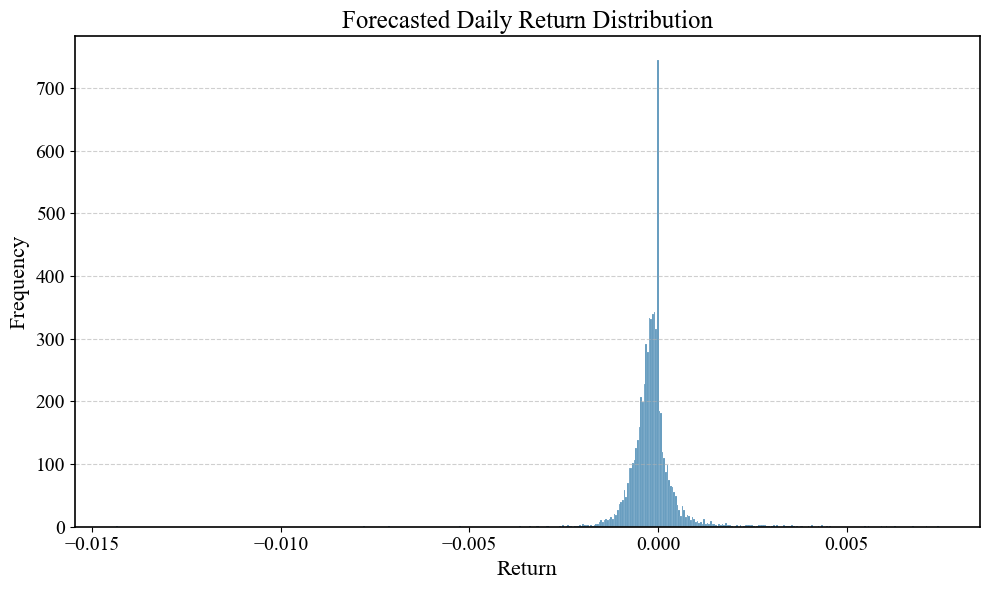

In [21]:
# Create styled figure and axis
fig, ax = plt.subplots(figsize=plot_style.get_figsize("wide"))

# Plot histogram using Seaborn
sns.histplot(pd_predictions['forecast'], ax=ax, color="#2874A6", edgecolor="white")

ax.set_title("Forecasted Daily Return Distribution")
ax.set_xlabel("Return")
ax.set_ylabel("Frequency")

# Apply your custom style
plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax)

In [22]:
# Import custom evaluation metrics
from genai4t.evaluation.metrics import (
    compute_investment_scores,
    get_cumulative_returns)

In [23]:
scores = (
    pd_predictions
    .groupby(['item_id'])
    .apply(
        lambda df: pd.Series(compute_investment_scores(df["target"], df["forecast"])))
    .reset_index()
)

In [24]:
scores

,item_id,mean,std,sharpe,cum_return,spearman_corr
0,currency_1,-0.000087,0.006249,-0.220768,-0.067410,-0.017075
1,currency_2,-0.000031,0.005930,-0.083478,-0.024731,0.041873
2,currency_3,-0.000019,0.004930,-0.060115,-0.014881,-0.073298
3,currency_4,0.000018,0.007243,0.040366,0.014899,-0.050163
4,currency_5,-0.000007,0.001723,-0.067217,-0.005841,0.011280
5,currency_6,-0.000099,0.005816,-0.269454,-0.076216,-0.021615
6,currency_7,-0.000017,0.006981,-0.039573,-0.013878,-0.032363
7,currency_8,0.000102,0.003414,0.475676,0.085623,0.020640


In [25]:
scores['cum_return'].sum()

-0.1024354100227356

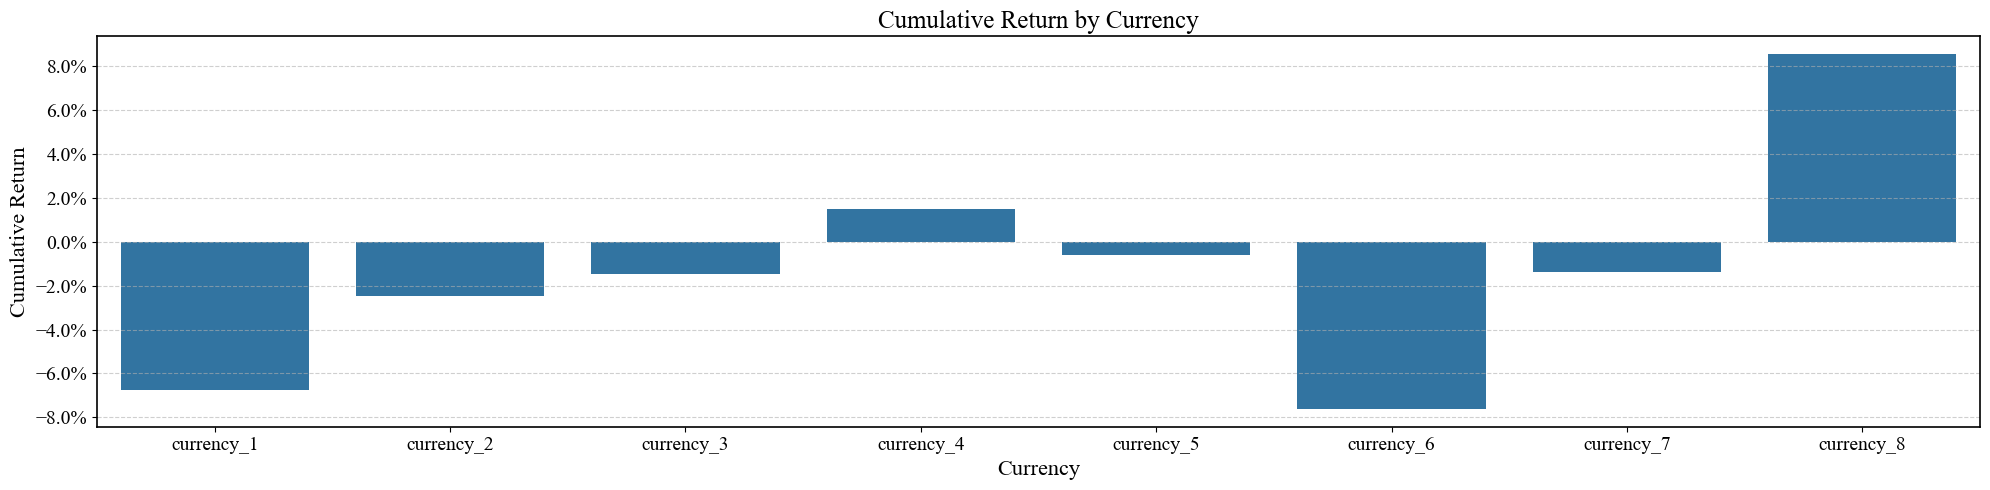

In [26]:
import matplotlib.ticker as mtick  
f, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x='item_id', y='cum_return', data=scores)
ax.set_title("Cumulative Return by Currency")
ax.set_xlabel("Currency")
ax.set_ylabel("Cumulative Return")

# Format y-axis as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax, axis="y")

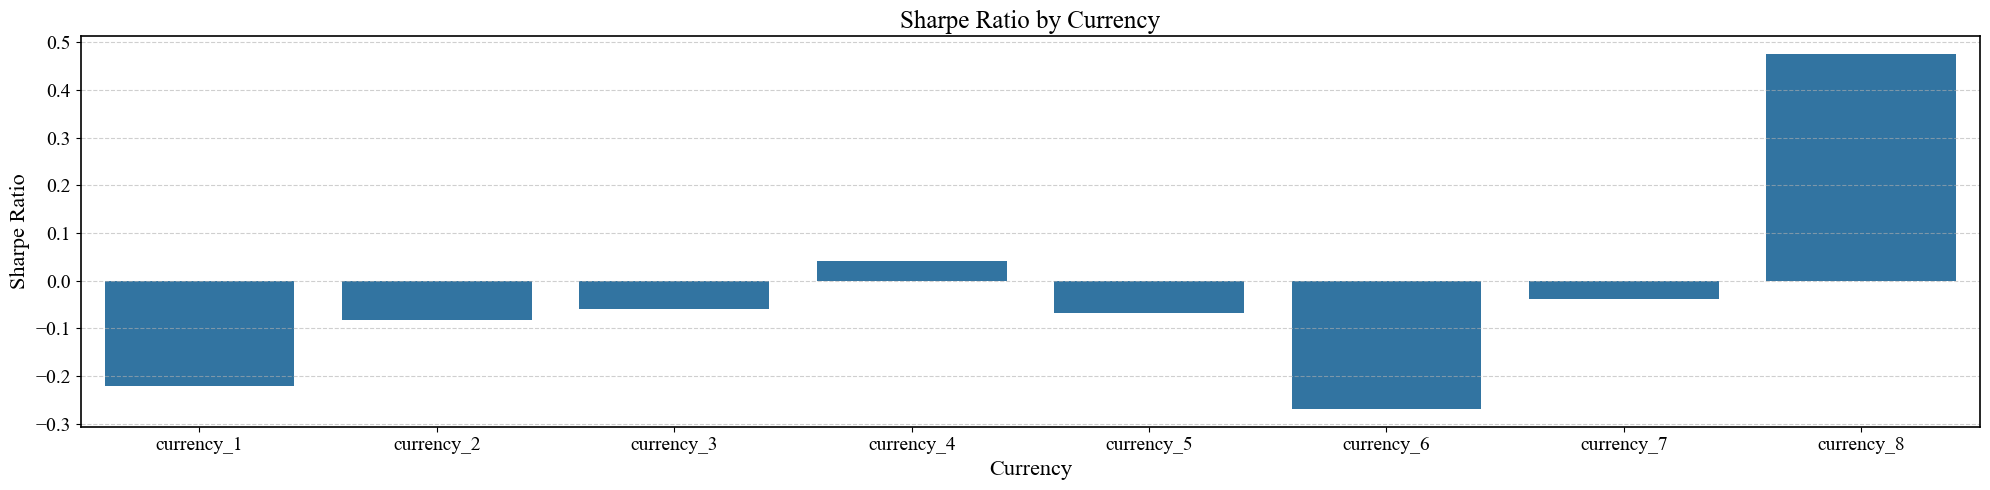

In [27]:
f, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x='item_id', y='sharpe', data=scores)
ax.set_title("Sharpe Ratio by Currency")
ax.set_xlabel("Currency")
ax.set_ylabel("Sharpe Ratio")

plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax, axis="y")

In [28]:
pd_predictions['cum_return'] = (
    pd_predictions
    .groupby(['item_id'], group_keys=False)
    .apply(lambda df: get_cumulative_returns(df['target'], df['forecast']))
)

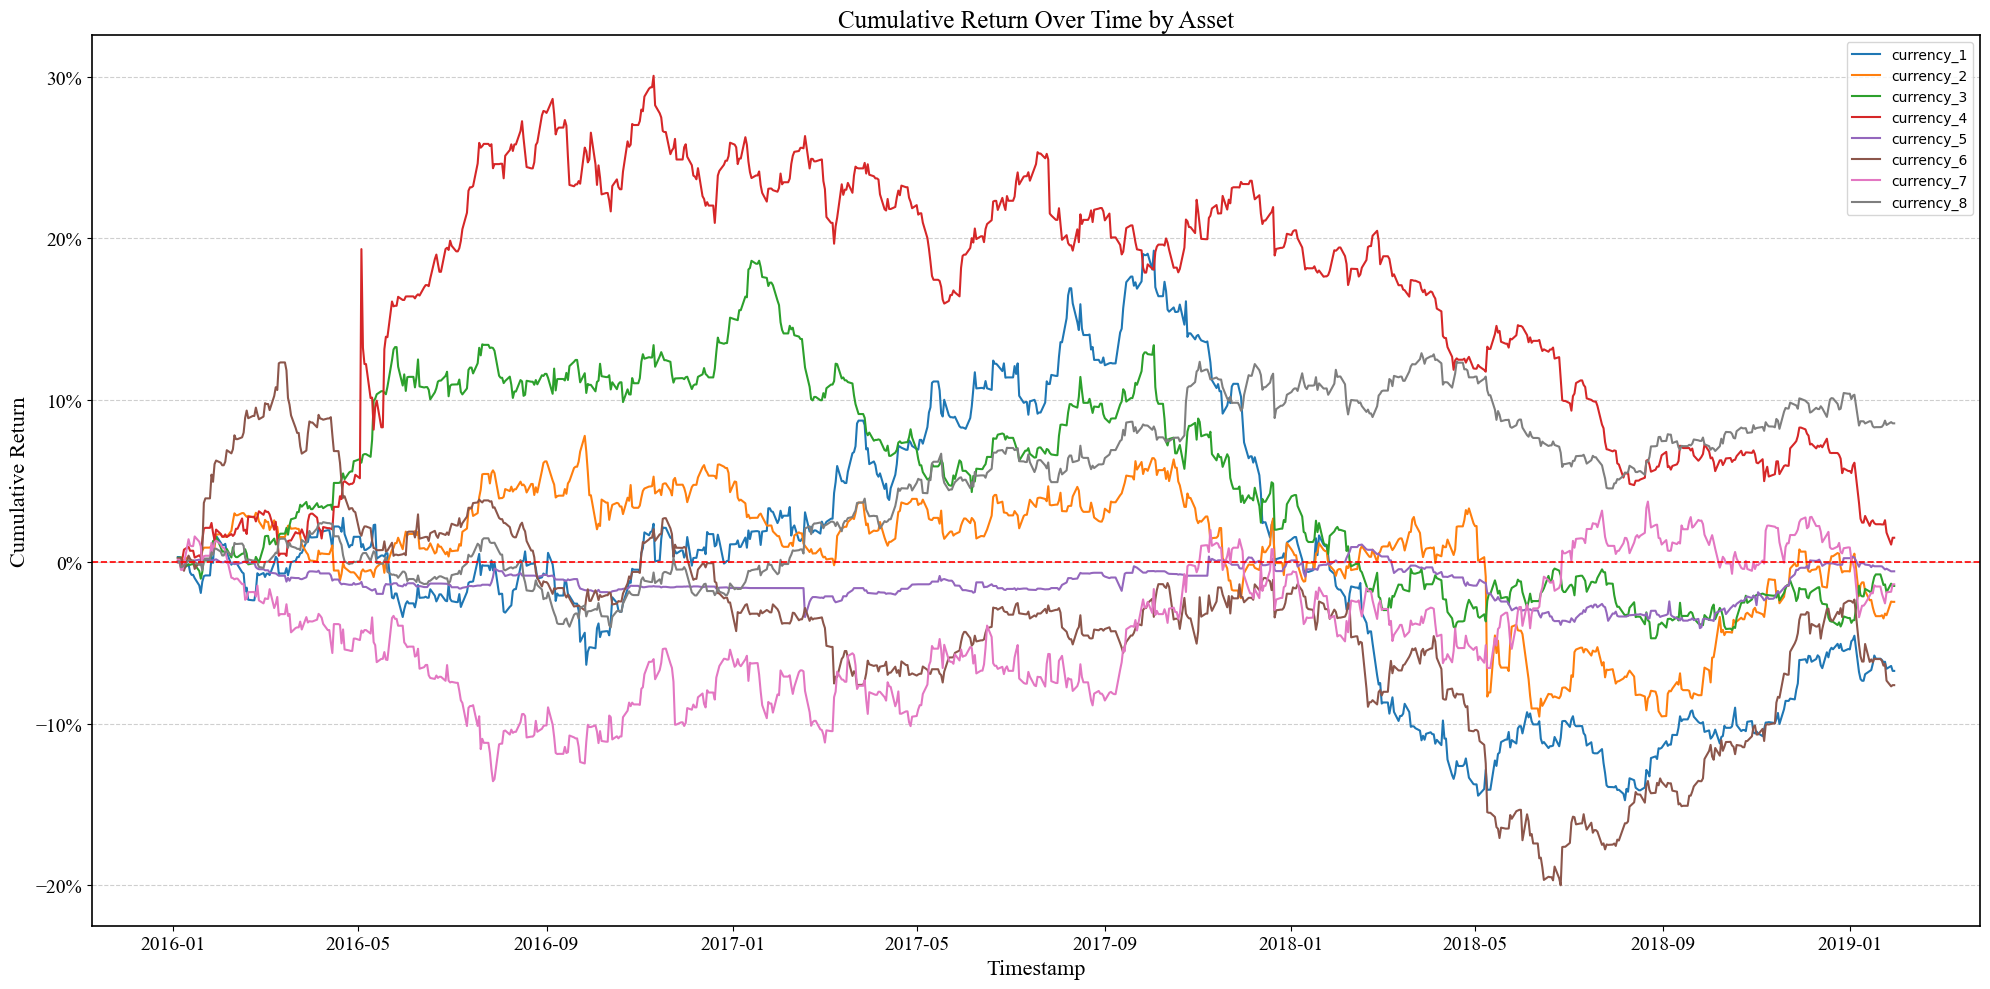

In [29]:
f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(
    x="timestamp",
    y='cum_return',
    hue='item_id',
    data=pd_predictions.reset_index(),
    ax=ax)

# Horizontal reference line at 0%
ax.axhline(0., color='red', linestyle='--', linewidth=1.2)


# Format y-axis as percentages (assuming cum_return is in decimal form)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


# Title and labels
ax.set_title("Cumulative Return Over Time by Asset")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Cumulative Return")

# Apply custom styling
plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax, axis="y")

# Handle legend (optional: move outside if too crowded)
ax.legend(loc="best")